<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/WQU_MScFE_NZD_JPY_Algorithmic_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Note: this is only a draft of a homework, the final Notebook will be released soon

In [11]:
!pip install pmdarima
!pip install git+https://github.com/pydata/pandas-datareader.git


  Cloning https://github.com/pydata/pandas-datareader.git to /tmp/pip-req-build-qt7857yv
  Running command git clone -q https://github.com/pydata/pandas-datareader.git /tmp/pip-req-build-qt7857yv
  Created wheel for pandas-datareader: filename=pandas_datareader-0.11.0.dev0+6.gfdade48-py3-none-any.whl size=109747 sha256=2076b43133d41d279db59207b583604ffe2e1272d846bfb9a0a070e9f09486de
  Stored in directory: /tmp/pip-ephem-wheel-cache-k58pabp2/wheels/54/6a/47/b1e68c4877ae6bf9a511e84e13972507e0fac9e17335156eb7
Successfully built pandas-datareader
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [8]:
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the trend 
# of the pair NZDJPY pair using the pair's prince history
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import datetime

from sklearn.metrics import mean_squared_error as MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')


In [22]:
#Get the stock quote 
nzdjpy = web.DataReader('NZDJPY=X', data_source='yahoo', start='2012-01-01', end='2021-03-01') 
#Show the data 
nzdjpy

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,59.950001,59.575001,59.889999,59.770000,0.0,59.770000
2012-01-03,60.630001,59.959999,60.039001,60.035999,0.0,60.035999
2012-01-04,60.609001,60.279999,60.609001,60.599998,0.0,60.599998
2012-01-05,60.417000,59.972000,60.290001,60.313000,0.0,60.313000
2012-01-06,60.480999,60.018002,60.229000,60.227001,0.0,60.227001
...,...,...,...,...,...,...
2021-02-24,78.416000,77.142998,77.261002,77.250000,0.0,77.250000
2021-02-25,79.183998,78.671997,78.820999,78.864998,0.0,78.864998
2021-02-26,78.372002,77.183998,78.338997,78.335999,0.0,78.335999


In [23]:
nzdjpy.shape

(2389, 6)

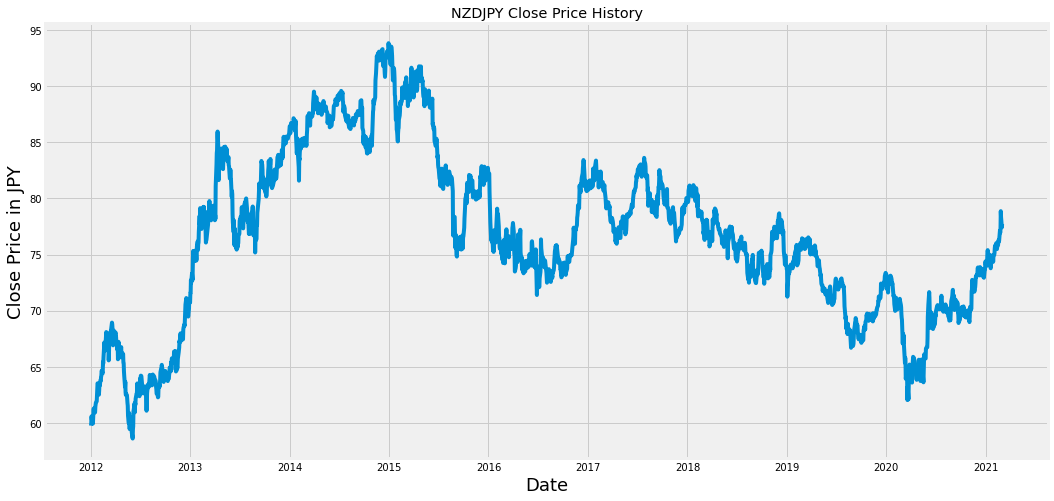

In [24]:
#Visualize the closing price history

plt.figure(figsize=(16,8))
plt.title('NZDJPY Close Price History')
plt.plot(nzdjpy['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price in JPY',fontsize=18)
plt.show()

In [25]:
# Initialize the short and long windows
short_window = 22 # <-- a month
long_window = 66 # <-- 3 months

# return threshold for LSTM (0.1 = 10%)
return_threshold = 0.1

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=btcusd.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = btcusd['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = btcusd['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)

            signal  short_mavg  long_mavg  positions
Date                                                
2012-01-02     0.0   59.770000  59.770000        NaN
2012-01-03     0.0   59.903000  59.903000        0.0
2012-01-04     0.0   60.135333  60.135333        0.0
2012-01-05     0.0   60.179749  60.179749        0.0
2012-01-06     0.0   60.189200  60.189200        0.0
...            ...         ...        ...        ...
2021-02-24     1.0   75.767518  74.505953        0.0
2021-02-25     1.0   75.956817  74.595938        0.0
2021-02-26     1.0   76.109849  74.675165        0.0
2021-03-01     1.0   76.249394  74.742226        0.0
2021-03-02     1.0   76.381076  74.810438        0.0

[2389 rows x 4 columns]


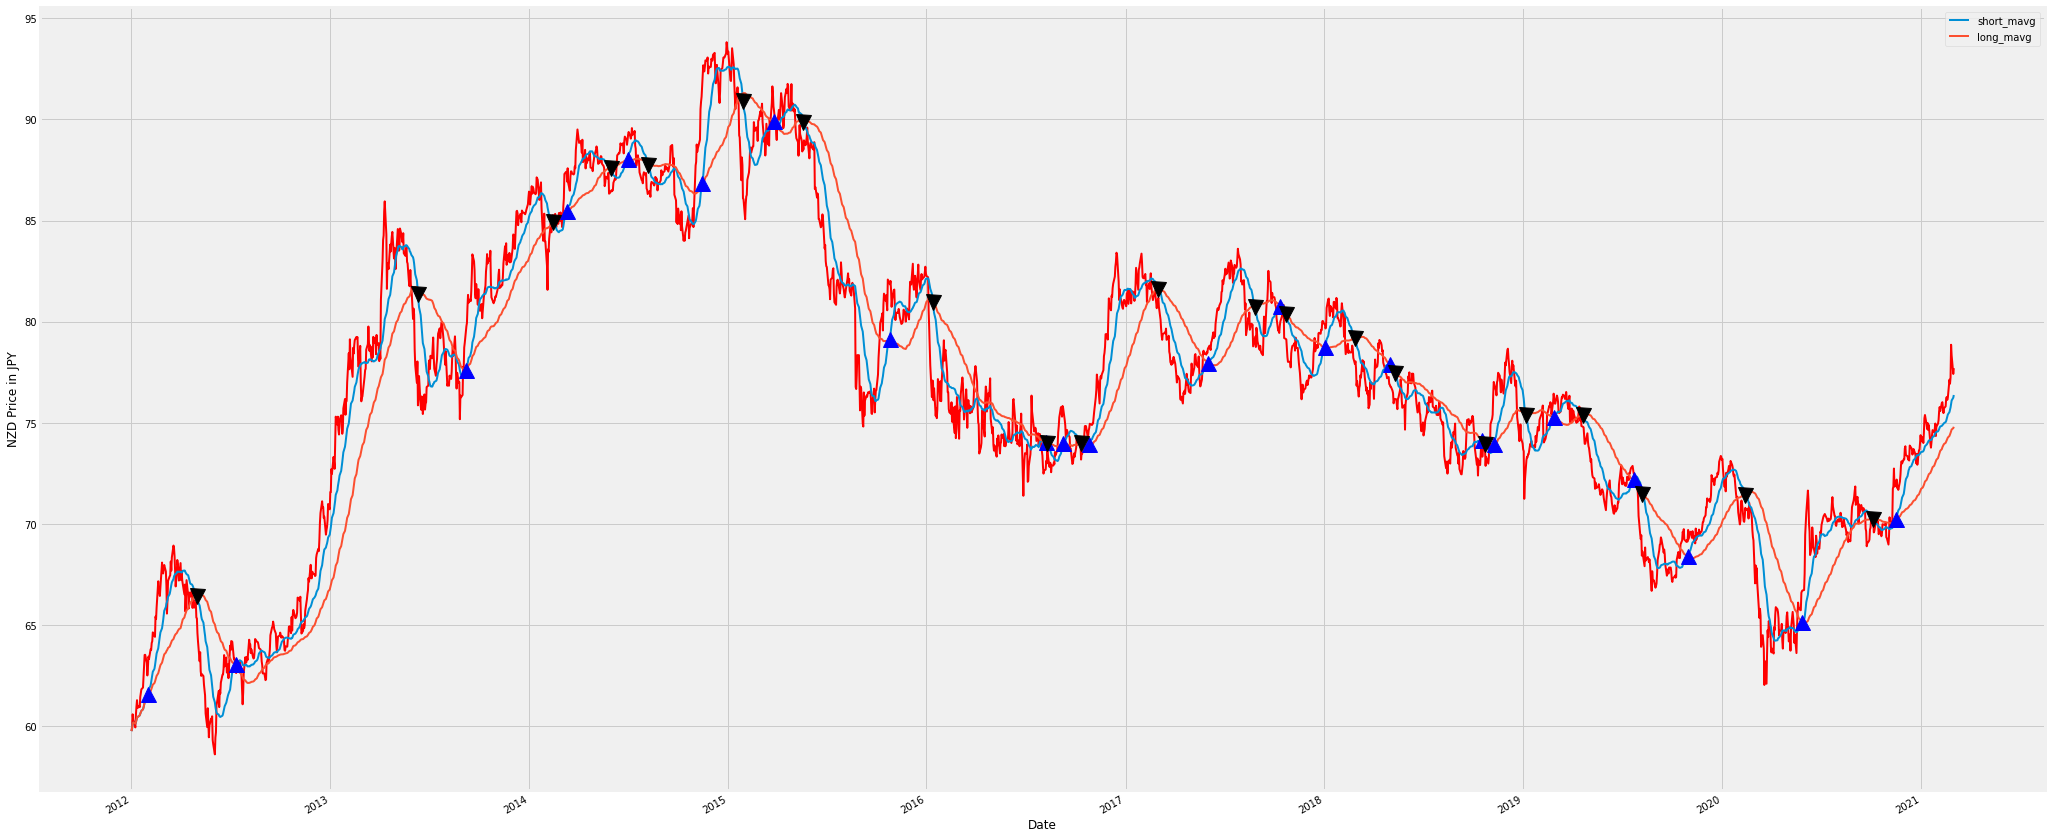

In [26]:
# Initialize the plot figure
fig = plt.figure(figsize=(32,16))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='NZD Price in JPY')

# Plot the closing price
nzdjpy['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=15, color='b')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=15, color='k')
         
# Show the plot
plt.show()

# Forecast NZDJPY close prices using a LSTM Model

In [38]:
#Create a new dataframe with only the 'Close' column
data = nzdjpy.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [39]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

# Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train =[]

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [40]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [41]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [42]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [43]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1852/1852 [==============================] - 60s 31ms/step - loss: 0.0024


In [45]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
#Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [46]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [47]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [48]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [56]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1.3654196169396013

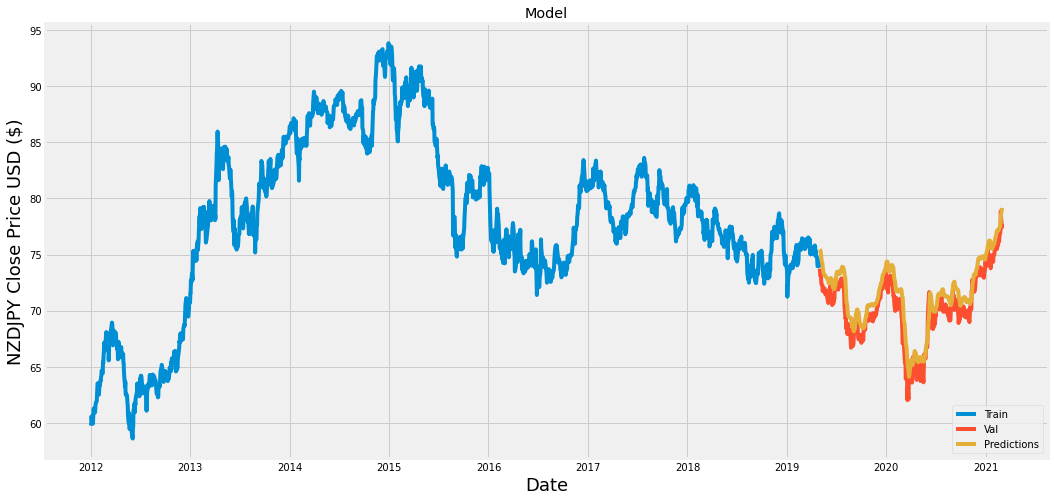

In [50]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('NZDJPY Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [51]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2019-05-02,73.755997,75.459747
2019-05-05,73.083000,75.356102
2019-05-06,73.207001,75.152191
2019-05-07,72.720001,74.951416
2019-05-08,72.430000,74.704041
...,...,...
2021-02-24,77.250000,77.853935
2021-02-25,78.864998,78.079201
2021-02-26,78.335999,78.546989


# Using the LSTM trained model to improve MA signals

In [52]:
# We would like test the model some more and get the predicted closing price of the pair NZDJPY. 
# Initialize the short and long windows
short_window = 22 # <-- a month
long_window = 66 # <-- 3 months

# return threshold for LSTM (0.1 = 10%)
return_threshold = 0.05

# get training data and predictions
model_data = pd.concat([train['Close'], valid['Predictions']])

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=nzdjpy.index)
signals['signal'] = 0.0

# Initialize the `signals` DataFrame with the `lstm_signal` column
signals['lstm_signal_short'] = 0.0
signals['lstm_signal_long'] = 0.0

# Initialize the `signals` DataFrame with the `predictions` column
signals['predictions'] = model_data

# Create short simple moving average over the short window
signals['short_mavg'] = nzdjpy['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = nzdjpy['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Create LSTM signals on MA signal points
for i in range (len(signals)):
  position = signals['positions'][i]
  signal = signals['signal'][i]
  if (position !=0):
    lstm_value_short = ((model_data[i+short_window]/data['Close'][i]) - 1)
    # get lstm long and short signals based on returns
    signals['lstm_signal_short'][i] = lstm_value_short

    # Eliminate  invalid MA signals
    if(abs(lstm_value_short)< return_threshold):
      signals['signal'][i] = 0.0
      signals['positions'][i] = 0.0

  i+= short_window


# Print `signals`
print(signals.loc[signals.lstm_signal_short !=0].head(40))

            signal  lstm_signal_short  ...  long_mavg  positions
Date                                   ...                      
2012-01-02     0.0           0.052200  ...  59.770000        NaN
2012-02-01     1.0           0.080935  ...  61.502348        1.0
2012-05-01     0.0          -0.095268  ...  66.522031       -1.0
2012-07-11     0.0           0.003052  ...  62.965940        0.0
2013-06-11     0.0           0.023909  ...  81.625530        0.0
2013-09-08     0.0           0.009627  ...  77.626652        0.0
2014-02-14     0.0           0.022082  ...  84.934788        0.0
2014-03-12     0.0           0.011067  ...  85.463197        0.0
2014-06-01     0.0           0.028710  ...  87.665303        0.0
2014-07-01     0.0          -0.017748  ...  87.958712        0.0
2014-08-07     0.0           0.016973  ...  87.861591        0.0
2014-11-14     0.0          -0.000011  ...  86.706606        0.0
2015-01-29     0.0           0.049954  ...  91.285561        0.0
2015-03-27     0.0       

# Plotting NZDJPY signals based on ARIMA, LSTM and MA crossovers

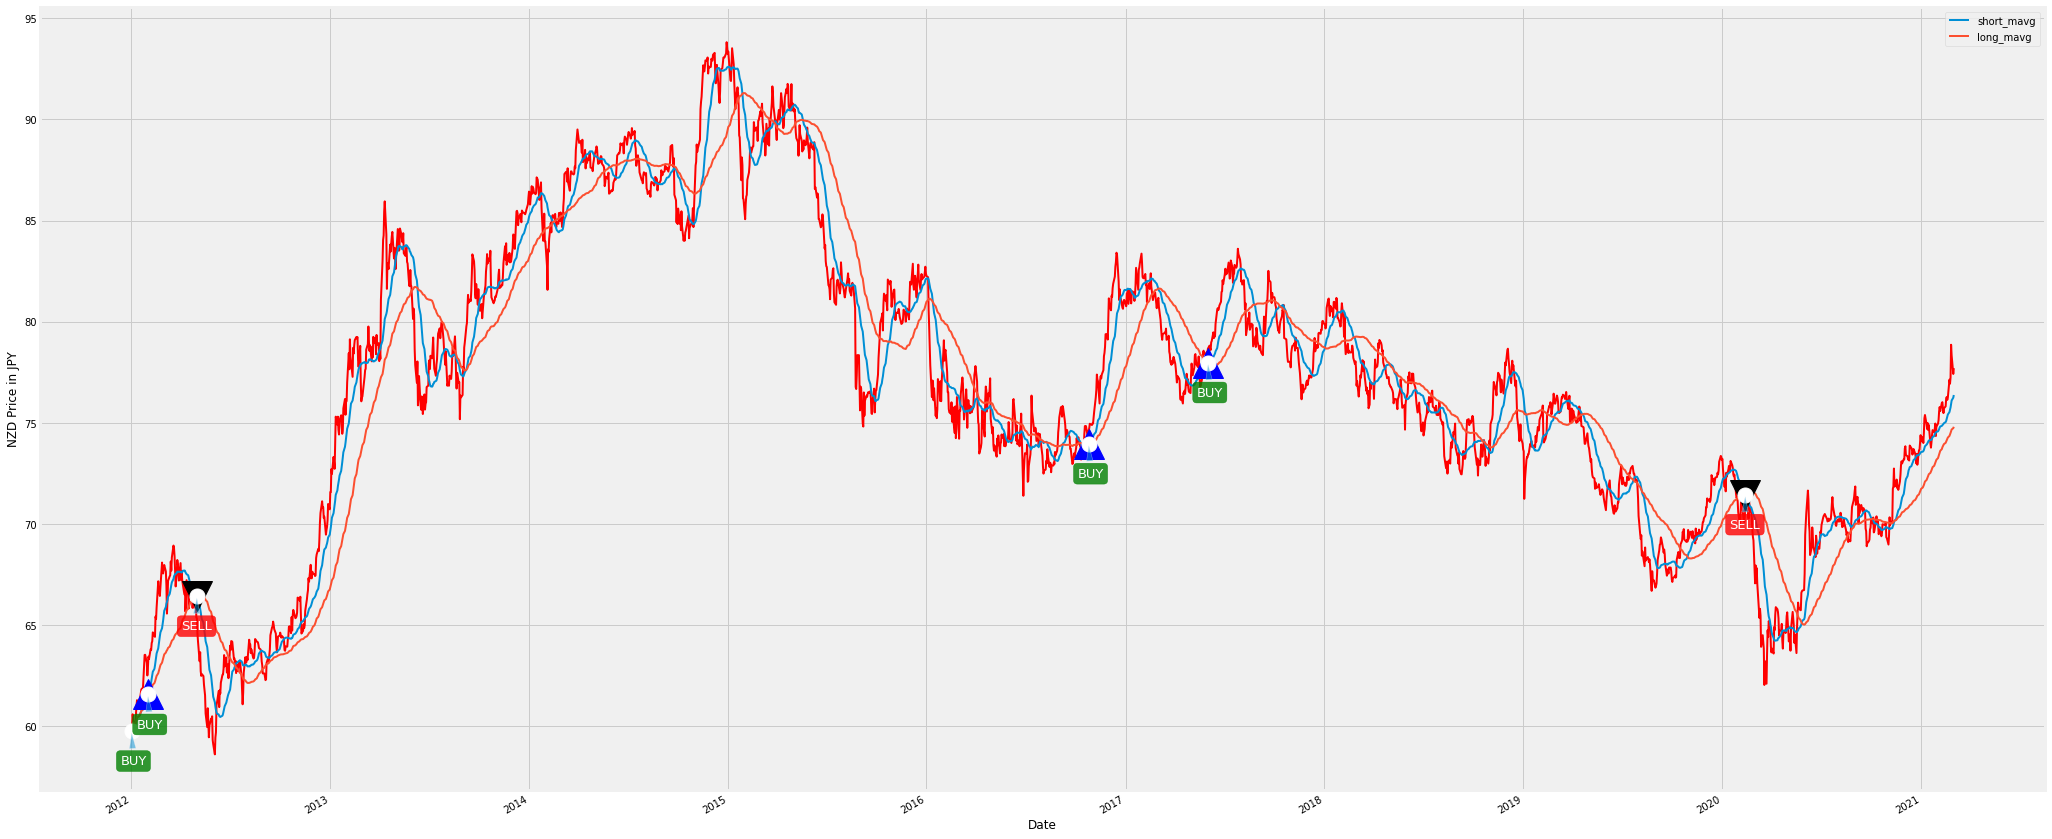

In [53]:
# Initialize the plot figure
w = 32
h = 16
fig = plt.figure(figsize=(w,h))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='NZD Price in JPY')

# Plot the closing price
nzdjpy['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=30, color='b')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=30, color='k')
         

for i in range (len(signals)):
  if(signals['lstm_signal_short'][i] > return_threshold ):
    ax1.annotate("BUY", xy=(signals.index[i], 
            signals.short_mavg[i]),  xycoords='data',
             xytext=(15, -30), textcoords='offset points',
             size=13, ha='right', va="center", color='white',
             bbox=dict(boxstyle="round", alpha=0.8, color='green'),
             arrowprops=dict( arrowstyle="wedge,tail_width=0.5", alpha=0.5))
    ax1.plot(signals.index[i], 
         signals.short_mavg[i],
         'o', markersize=15, color='w') 
    
  elif(signals['lstm_signal_short'][i] < -return_threshold ):
    ax1.annotate("SELL", xy=(signals.index[i], 
            signals.short_mavg[i]),  xycoords='data',
             xytext=(15, -30), textcoords='offset points',
             size=13, ha='right', va="center", color='white',
             bbox=dict(boxstyle="round", alpha=0.8, color='red'),
             arrowprops=dict( arrowstyle="wedge,tail_width=0.5", alpha=0.5))  
    ax1.plot(signals.index[i], 
         signals.short_mavg[i],
         'o', markersize=15, color='w') 
  


# Show the plot
plt.show()


# Calculating returns and cumulative returns

In [54]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['nzdjpy'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(nzdjpy['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(nzdjpy['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(nzdjpy['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio[::long_window].head(40))

                 nzdjpy     holdings           cash          total   returns
Date                                                                        
2012-01-02     0.000000     0.000000  100000.000000  100000.000000       NaN
2012-04-02  6723.000336  6723.000336   93711.000061  100434.000397 -0.000840
2012-07-03     0.000000     0.000000  100245.200348  100245.200348  0.000000
2012-10-03  6438.800049  6438.800049   93981.400299  100420.200348 -0.000115
2013-01-04  7248.000336  7248.000336   93981.400299  101229.400635 -0.000234
2013-04-07  8301.100159  8301.100159   93981.400299  102282.500458  0.001875
2013-07-08     0.000000     0.000000  101568.500519  101568.500519  0.000000
2013-10-08  8054.499817  8054.499817   93573.900604  101628.400421  0.000364
2014-01-09  8659.100342  8659.100342   93573.900604  102233.000946 -0.000077
2014-04-10  8788.999939  8788.999939   93342.501068  102131.501007 -0.001085
2014-07-13  8930.899811  8930.899811   93066.101074  101997.000885  0.000067

# Visualizing the portfolio's values

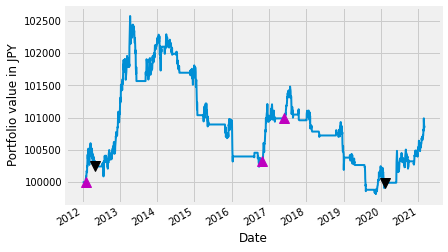

In [55]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in JPY')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()